## Neural networks for segmentation

In [ ]:
!wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
!unzip -q data.zip

--2021-06-01 17:17:46--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2021-06-01 17:17:47--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce1ee415f20dfa0d78e63097e76.dl.dropboxusercontent.com/cd/0/inline/BPmV8XEWuw5CvNk9b-FpI8Yb3i0R6NpM6rR3ywbTKIWHwTxo-uAsNw_fEKJ5HHm9L7CVslc9-8WYqCB6sVAw1XE3mTqbew3lTjqxYBoxbZ_GteFu1rft6j1OMs3v8pc_w4Rll6sfos64gN9zJ4UQI4_4/file# [following]
--2021-06-01 17:17:47--  https://uce1ee415f20dfa0d78e63097e76.dl.dropboxusercontent.com/cd/0/inline/BPmV8XEWuw5CvNk9b-FpI8Yb3i0R6NpM6rR3ywbTKIWHwTxo-uAsNw_fEKJ5HHm9L7CVslc9-8WYqCB6sVAw1XE3mTqbew3lT

In [3]:
!ls

data.zip  images  masks  sample_data


In [ ]:
!mv BBBC018_v1_images-fixed images
!mv BBBC018_v1_outlines/ masks

In [4]:
from __future__ import annotations

from typing import Optional, Tuple, List, Dict

import os
from functools import partial
from itertools import islice
from collections import defaultdict

import numpy as np
from skimage.io import imread
from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader
from torch.utils.data._utils.collate import default_collate

import albumentations
import albumentations as albu

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
input = torch.randn(1, 3, 3, 3)

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 38.2MB 75kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Dataset

In [5]:
class Batch:
    
    def __init__(self, image: torch.Tensor, mask: torch.Tensor, filename: Optional[str] = None) -> None:
        self.image = image
        self.mask = mask
        self.filename = filename
    
    def to(self, device: torch.device) -> Batch:
        self.image = self.image.to(device)
        self.mask = self.mask.to(device)
        return self
    
    def __len__(self):
        return self.image.shape[0]
    
    def __iter__(self):
        for _ in [self.image, self.mask]:
            yield _


class Collator:
    
    def __call__(self, d: List[Dict]) -> Batch:
        d = default_collate(d)
        batch: Batch = Batch(d['image'], d['mask'], d['path'])
        return batch
        

class SegmentationDataset(Dataset):
    IMAGE_EXTENTION = "DIB.bmp"
    MASK_EXTENTION = "png"
    
    def __init__(
        self,
        image_root: str,
        mask_root: str,
        augmentation: Optional[albumentations.Compose] = None,
        preprocessing: Optional[albumentations.Compose] = None,
    ) -> None:
        super().__init__()
        self.image_root = image_root
        self.mask_root = mask_root
        
        self.images = sorted(os.listdir(image_root))
        self.masks = sorted(os.listdir(mask_root))
        assert len(self.images) == len(self.masks)
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self, index: int) -> Batch:
        image = imread(os.path.join(self.image_root, self.images[index]))
        mask = imread(os.path.join(self.mask_root, self.masks[index]))
        
        if self.augmentation is not None:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
            
        if self.preprocessing is not None:
            augmented = self.preprocessing(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
    
        return {'image': image, 'mask': mask, 'path': self.images[index]}
        
        
    def __len__(self) -> int:
        return len(self.images)

In [6]:
dataset = SegmentationDataset('images/train/', 'masks/train/')

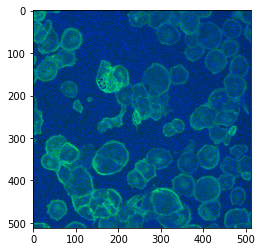

In [9]:
plt.imshow(dataset[0]['image'])

In [11]:
dataset[0]['mask']

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Preprocessing and Augmentation

In [12]:
# TODO добавить RandomPatchCrop
# + Padding

augmentation = albu.Compose([
    albu.VerticalFlip(),
    albu.RandomRotate90(),
    # TODO Уменьшить параметры, чтобы так сильно не рвало изображение
    albu.OneOf(
        [
            albu.GridDistortion(distort_limit=.5, interpolation=2),
            albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, interpolation=2),
            albu.OpticalDistortion(p=1, distort_limit=1, shift_limit=0.1, interpolation=2),
        ],
        p=0.75
    ),
    albu.CLAHE(clip_limit=3, p=0.7),
    albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.8),
    albu.RandomGamma(gamma_limit=(40, 120), p=0.8)
])

def _select_channel(image: np.ndarray, **kwargs):
    return image[:, :, 1:2]

def _to_binary_mask(mask: np.ndarray, **kwargs):
    mask[mask != 0] = 1
    return mask

def _convert_image(image: np.ndarray, **kwargs):
    image = np.repeat(image, 3, -1)
    return torch.from_numpy(image).float().permute(2, 0, 1)

def _convert_mask(mask: np.ndarray, **kwargs):
    return torch.from_numpy(mask).float()

preprocessing = albu.Compose([
    albumentations.augmentations.transforms.Lambda(image=_select_channel),
    albumentations.augmentations.transforms.ToFloat(),
    albumentations.augmentations.transforms.Lambda(image=_convert_image),
    
    albumentations.augmentations.transforms.Lambda(mask=_to_binary_mask),
    albumentations.augmentations.transforms.Lambda(mask=_convert_mask)
])

dataset = SegmentationDataset('images/train/', 'masks/train/',
                              augmentation=augmentation, preprocessing=preprocessing)

In [23]:
result = dataset[0]

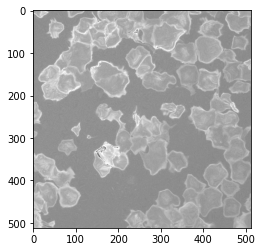

In [25]:
plt.imshow(result['image'].permute(1, 2, 0))

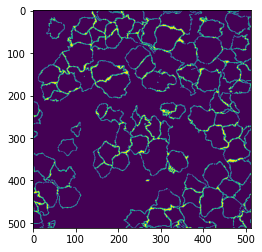

In [26]:
plt.imshow(result['mask'])

# Visualization Utils

In [27]:
def plot_image_mask(batch: Batch, max_num=-1):
    def _process(input):
        if isinstance(input, torch.Tensor):
            input = input.numpy()
        if input.shape[0] == 3:
            input = np.transpose(input, [1, 2, 0])
        return np.squeeze(input)
    
    if max_num == -1:
        max_num = len(batch)
    else:
        max_num = min(max_num, len(batch))
    
    fig, axes = plt.subplots(max_num, 2, dpi=150, figsize=(7, 3.5 * max_num))
    if axes.ndim == 1:
        axes = axes[np.newaxis, :]
    
    for i, (image, mask) in enumerate(zip(batch.image[:max_num], batch.mask[:max_num])):
        axes[i, 0].imshow(_process(image))
        axes[i, 1].imshow(_process(mask))
        
    plt.show()
    
def plot_triplets(triplets):
    fig, axes = plt.subplots(len(triplets), 4, figsize=(3.5 * 4, 3.5 * len(triplets)))
    if axes.ndim == 1:
        axes = axes[np.newaxis, :]
        
    for i, (image, prediction, hard_prediction, mask) in enumerate(triplets):
        axes[i, 0].imshow(image[0].transpose(1, 2, 0))
        axes[i, 1].imshow(prediction[0])
        axes[i, 2].imshow(hard_prediction[0])
        axes[i, 3].imshow(mask[0])
    
    plt.show()

# Patching/Unpatching

In [28]:
def patching(image: torch.Tensor, crop_size=2):
    C, H, W = image.shape
    assert image.dim() == 3
    
    image = image.unfold(-2, crop_size, crop_size)
    image = image.unfold(-2, crop_size, crop_size)
    image = image.flatten(-4, -3).transpose(0, 1)
    
    return image, H // crop_size, W // crop_size

def unpatching(image, h_patch, w_patch):
    _, C, H, W = image.shape
    image = image.reshape(1, h_patch, w_patch, H, W)
    image = image.transpose(2, 3).flatten(1, 2).flatten(-2, -1)
    
    return image

input = torch.arange(6 * 6).reshape(1, 6, 6)
assert torch.allclose(input, unpatching(*patching(input, 2)))
assert torch.allclose(input, unpatching(*patching(input, 3)))
assert torch.allclose(input, unpatching(*patching(input, 6)))

# Model
    - U-NET 

In [29]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 71kB 3.1MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 245kB 27.2MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=4cf9796d14596070b9e6a78824565bcee6c3bf28fda63c36a08aad084a472441
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=a5e5accf0d6671c6cd90d74bb89ff6323c2ca486a02c56dbe735f5ac603894c4
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch


In [30]:
import segmentation_models_pytorch as smp

In [31]:
unet_model = smp.Unet()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


# Criterion
    - BCE
    - Focal loss
    - DICE
    - BCE + DICE

In [ ]:
# bce_criterion = nn.CrossEntropyLoss()
# dice_criterion = ...

# Metrics

In [35]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()

    return float(intersection) / union


class AverageMeter(object):
    
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

# Train/Val routines

In [36]:
def train(experiment):
    losses = AverageMeter('Loss', ':.4e')
    iou_metric = AverageMeter('IoU', ':6.2f')

    experiment.model.train()
    for batch in tqdm(experiment.train_dataloader):
        batch.to(experiment.device)

        batch_size = len(batch)
        image, mask = batch

        logits = experiment.model(image).squeeze(1)
        loss = experiment.criterion(logits, mask)

        experiment.optimizer.zero_grad()
        loss.backward()
        experiment.optimizer.step()

        losses.update(loss.item(), batch_size)

        hard_prediction = (logits.detach().sigmoid().cpu().numpy() > experiment.threshold).astype(float)
        iou_metric.update(calc_iou(hard_prediction, mask.cpu().numpy()), batch_size)
    
    return losses, iou_metric

def validate(experiment):
    losses = AverageMeter('Loss', ':.4e')
    iou_metric = AverageMeter('IoU', ':6.2f')
    triplets = []
    
    experiment.model.eval()
    for batch in tqdm(experiment.val_dataloader):
        batch.to(experiment.device)
        
        batch_size = len(batch)
        image, mask = batch
        
        with torch.no_grad():
            patches, h_patch, w_patch = patching(image.squeeze(0), experiment.random_crop)
            patches_logits = experiment.model(patches)
            logits = unpatching(patches_logits, h_patch, w_patch)
            loss = experiment.criterion(logits, mask)
        
        losses.update(loss.item(), batch_size)
        
#         prediction = (logits.sigmoid().cpu().numpy() > experiment.threshold).astype(float)
        prediction = (logits.sigmoid().cpu().numpy()).astype(float)
        hard_prediction = (prediction > experiment.threshold).astype(float)
        iou_metric.update(calc_iou(hard_prediction, mask.cpu().numpy()), batch_size)
        
        triplets.append((image.cpu().numpy(), prediction, hard_prediction, mask.cpu().numpy()))
    
    return losses, iou_metric, triplets

# Experiment №1
    - lr 1e-3
    - random_crop x2
    - Unet (backbone based on resnet-34 pretrained on imagenet)
    - CE
    - Adam with vanilla LR scheduler (i.e. without :))
    - Augmentation:
        RandomCrop256, VerticalFlip, RandomRotate90

In [38]:
class experiment_1:
    device = torch.device('cuda:0')
    epoch = 150
    log_plots = True
    history = defaultdict(list)
    random_crop = 512 // 2
    threshold = 0.25

    model = smp.Unet().to(device)
    optimizer = Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss().to(device)
    
    train_augmentation = augmentation = albu.Compose([
        albu.RandomCrop(random_crop, random_crop),
        albu.VerticalFlip(),
        albu.RandomRotate90(),
    ])
    
    train_dataset = SegmentationDataset('images/train/', 'masks/train/',
                                        augmentation=train_augmentation,
                                        preprocessing=preprocessing)
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4,
                                  pin_memory=True if device.type.find('cuda') != -1 else False, drop_last=True,
                                  collate_fn=Collator())
    
    val_dataset = SegmentationDataset('images/val/', 'masks/val/',
                                      preprocessing=preprocessing)
    val_dataloader = DataLoader(val_dataset, num_workers=4,
                                pin_memory=True if device.type.find('cuda') != -1 else False,
                                collate_fn=Collator())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


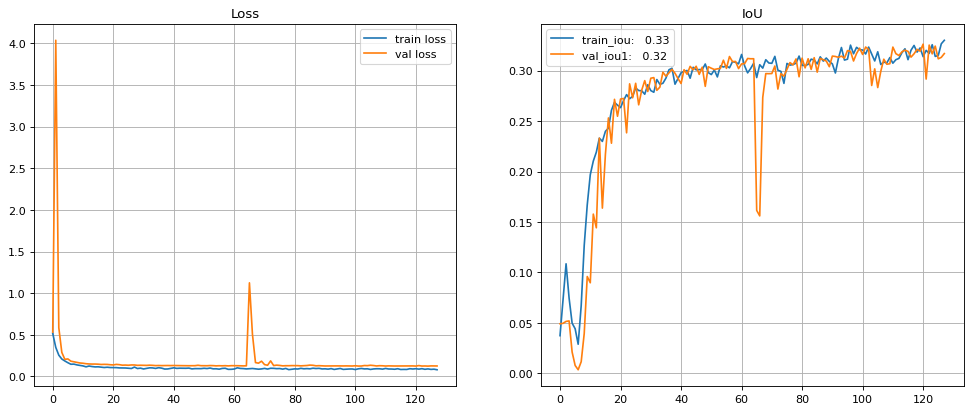

KeyboardInterrupt: ignored

In [39]:
for _ in tqdm(range(experiment_1.epoch)):
    losses, iou_metric = train(experiment_1)
    
    experiment_1.history['train_loss'].append(losses.avg)
    experiment_1.history['train_iou'].append(iou_metric.avg)
    
    losses, iou_metric, triplets = validate(experiment_1)
    
    experiment_1.history['val_loss'].append(losses.avg)
    experiment_1.history['val_iou'].append(iou_metric.avg)
    
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, dpi=80, figsize=(15, 6))
    
    axes[0].plot(experiment_1.history['train_loss'], label='train loss')
    axes[0].plot(experiment_1.history['val_loss'], label='val loss')

    axes[1].plot(experiment_1.history['train_iou'],
                 label='train_iou: {:6.2f}'.format(experiment_1.history['train_iou'][-1]))
    axes[1].plot(experiment_1.history['val_iou'],
                 label='val_iou1: {:6.2f}'.format(experiment_1.history['val_iou'][-1]))

    axes[0].legend(); axes[0].grid(); axes[0].set_title('Loss')
    axes[1].legend(); axes[1].grid(); axes[1].set_title('IoU')
    
    plot_triplets(triplets[:2])

In [ ]:
losses, iou_metric, triplets = validate(experiment_1)

# Experiment №2 (add)
    - Augmentation:
        CLAHE, Brightness, RandomGamma and OneOf[GridDistortion, ElasticTransform, OpticalDistortion]

In [ ]:
class experiment_2:
    device = torch.device('cuda:0')
    epoch = 150
    log_plots = True
    history = defaultdict(list)
    random_crop = 512 // 2
    threshold = 0.25

    model = smp.Unet().to(device)
    optimizer = Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss().to(device)
    
    train_augmentation = augmentation = albu.Compose([
        albu.RandomCrop(random_crop, random_crop),
        albu.VerticalFlip(),
        albu.RandomRotate90(),
        albu.OneOf(
            [
                albu.GridDistortion(distort_limit=.5, interpolation=2),
                albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, interpolation=2),
                albu.OpticalDistortion(p=1, distort_limit=1, shift_limit=0.1, interpolation=2),
            ],
            p=0.75
        ),
        albu.CLAHE(clip_limit=3, p=0.7),
        albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.8),
        albu.RandomGamma(gamma_limit=(40, 120), p=0.8)
    ])
    
    train_dataset = SegmentationDataset('images/train/', 'masks/train/',
                                        augmentation=train_augmentation,
                                        preprocessing=preprocessing)
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4,
                                  pin_memory=True if device.type.find('cuda') != -1 else False, drop_last=True,
                                  collate_fn=Collator())
    
    val_dataset = SegmentationDataset('images/val/', 'masks/val/',
                                      preprocessing=preprocessing)
    val_dataloader = DataLoader(val_dataset, num_workers=4,
                                pin_memory=True if device.type.find('cuda') != -1 else False,
                                collate_fn=Collator())

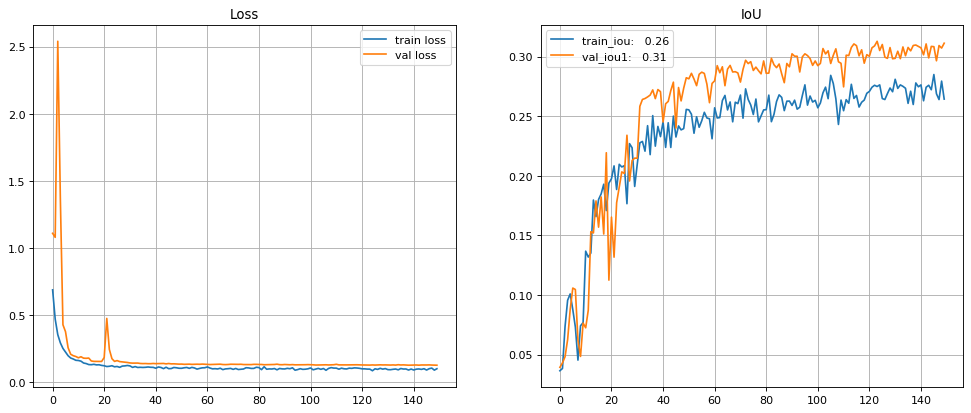

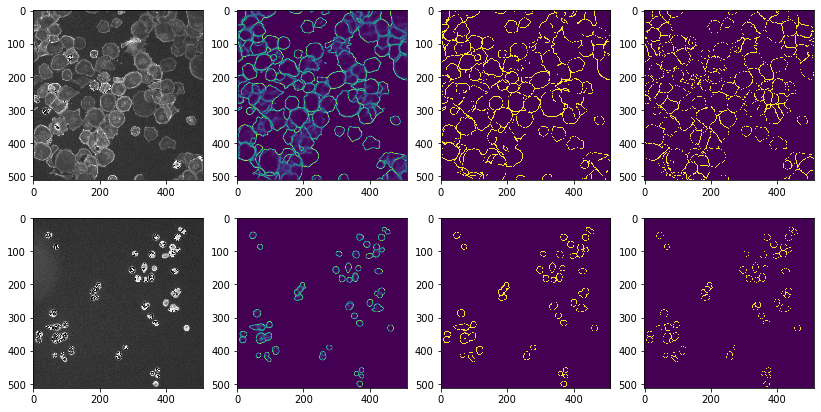


















100%|██████████| 150/150 [09:04<00:00,  3.63s/it]


In [ ]:
for _ in tqdm(range(experiment_2.epoch)):
    losses, iou_metric = train(experiment_2)
    
    experiment_2.history['train_loss'].append(losses.avg)
    experiment_2.history['train_iou'].append(iou_metric.avg)
    
    losses, iou_metric, triplets = validate(experiment_2)
    
    experiment_2.history['val_loss'].append(losses.avg)
    experiment_2.history['val_iou'].append(iou_metric.avg)
    
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, dpi=80, figsize=(15, 6))
    
    axes[0].plot(experiment_2.history['train_loss'], label='train loss')
    axes[0].plot(experiment_2.history['val_loss'], label='val loss')

    axes[1].plot(experiment_2.history['train_iou'],
                 label='train_iou: {:6.2f}'.format(experiment_2.history['train_iou'][-1]))
    axes[1].plot(experiment_2.history['val_iou'],
                 label='val_iou1: {:6.2f}'.format(experiment_2.history['val_iou'][-1]))

    axes[0].legend(); axes[0].grid(); axes[0].set_title('Loss')
    axes[1].legend(); axes[1].grid(); axes[1].set_title('IoU')
    
    plot_triplets(triplets[:2])